# Assignment 4: Supervised Learning, Decision Trees, Random Forests, and SVM Models

**Objective:** In this assignment we will develop predictive models - decision trees, random forest, and SVM models from sklearn library. We will also experiment with grid search and random search.


Please do not share this material on any platform or by any other means.

Important Notes:

    Make changes to the cells that have # YOUR CODE HERE or # YOUR COMMENT HERE.Do not write your answer in anywhere else other than where it says YOUR CODE HERE (or YOUR COMMENT HERE).

    Your code must run without any errors start to end. Please go to menubar, select Kernel, and restart the kernel and run all cells (Restart & Run all) before submitting your work.

    Purpose of the assignment is to assess your knowledge and command of the data mining algorithms, python programming language, and your ability to resolve common errors. Grading is based on the code and your interpretation/comments you are submitting, not the formatting of the results.

    Please use the examples as a guideline, you are not expected to have the same formatting as the example, unless it is a formatting question.

Remember, there are many ways to code that can lead to the correct answer, do not hesitate to exercise your own style and python programming coventions.

In this assignment you'll develop an understanding of decision trees, random forest using a mock-dataset called moons dataset, then build a SVM model to predict the California dataset. 

## PART 1: DECISION TREES

### Q1: Generate a moons dataset using make_moons(n_samples=10000, noise=0.4).
Random state = 42.

In [20]:
#YOUR CODE HERE
from sklearn.datasets import make_moons
# moons dataset
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)




If you are successful in creating the dataset, it may look like this:

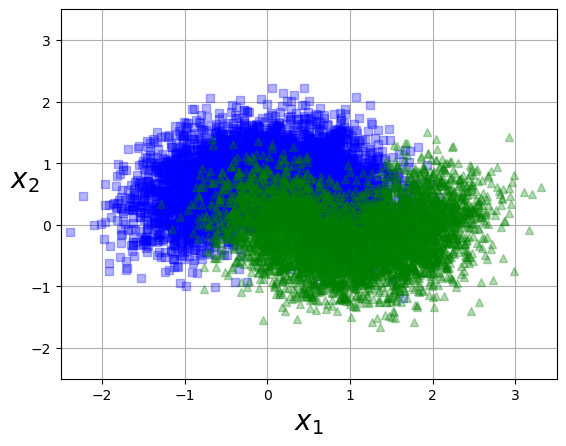

In [21]:
import matplotlib.pyplot as plt
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs",alpha=0.3)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^",alpha=0.3)
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-2.5, 3.5, -2.5, 3.5])
plt.show();

### Q2:  Split the data into a training set and a test set using train_test_split().
Random state = 42.

In [22]:
#YOUR CODE HERE
from sklearn.model_selection import train_test_split

# Split into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



### Q3: Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier. 
Test various values for max_leaf_nodes.

In [23]:
#YOUR CODE HERE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Our parameter grid
param_grid = {
    'max_depth': [3, 5,10, 7, 9,20, 30,100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initializing DecisionTreeClassifier
tree_classifier = DecisionTreeClassifier(random_state=42)

# Initializing GridSearchCV
grid_search = GridSearchCV(tree_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Extractting the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Extractting the best model
best_model = grid_search.best_estimator_

# Evaluating the best model on the test data
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.856


### Q4: Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. 
You may get roughly 85% to 87% accuracy.

In [24]:
#YOUR CODE HERE
from sklearn.tree import DecisionTreeClassifier

# hyperparameter tuning
best_tree_classifier = DecisionTreeClassifier(max_depth=best_params['max_depth'],
                                              min_samples_split=best_params['min_samples_split'],
                                              min_samples_leaf=best_params['min_samples_leaf'],
                                              random_state=42)
best_tree_classifier.fit(X_train, y_train)

# Model's performance
test_accuracy = best_tree_classifier.score(X_test, y_test)
print("Test Accuracy (Full Training Set):", test_accuracy)


Test Accuracy (Full Training Set): 0.856


In [25]:
# Test accuracy of same values indicates that the model is well banlanced and no sign of overfiting. Model has learned well-
# to generalize to unseen data. It's a good and robust model , well -trained and good generalization ability indicating a -
# robust and a reliable model.




## Creating many decision trees

Let's continue to use the same dataset as before and generate 1,000 subsets of the training set, each containing 100 instances selected randomly. We will use Scikit-Learn's ```ShuffleSplit``` class for this:

In [26]:
from sklearn.model_selection import ShuffleSplit
n_trees = 1000
n_instances = 100
mini_sets = []
rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

Let's use the best estimater values we found in question 3, and 
(1) generate the 1000 trees, and call it our "forest"
(2) fit and calculate the accuracy scores for each decision tree

In [29]:
from sklearn.base import clone
import numpy as np

# Initializing a list to store the forest of decision trees
forest = [clone(best_model) for _ in range(n_trees)]

# Initializing a list
accuracy_scores = []

# Iteratting through the forest and fitting  
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
  
    accuracy_score = tree.score(X_test, y_test)
    accuracy_scores.append(accuracy_score)

# Mean accuracy score 
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy across 1000 decision trees:", mean_accuracy)


Mean Accuracy across 1000 decision trees: 0.8275540000000001


Since each decision tree is trained on a smaller dataset (100 examples) than the one in Q4 (10000 examples), the accuracy score is lower.  

### Majority Vote

For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's mode() function for this). This gives you **majority-vote predictions** over the test set.

In [33]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [36]:
from scipy.stats import mode

# Compute the mode of predictions along each column (axis=0) of Y_pred
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)


In [39]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))
print(accuracy)

0.8596666666666667


## PART 2: RANDOM FOREST

### Q5: Build a random forest model with 1000 trees, and check the accuracy score.
Random state = 42. 

In [40]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initializing Random Forest Classifier with 1000 trees
random_forest = RandomForestClassifier(n_estimators=1000, random_state=42)

# Fitting the model on the training data
random_forest.fit(X_train, y_train)

# Making predictions on the test data
y_pred = random_forest.predict(X_test)

# Calculating the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)


Accuracy Score: 0.847


### Q6: Use GridSearchCV to find a Random Forest model, is it better or worse than 1000-Decision Trees majority vote (compare to Q5 accuracy)? 
Random state = 42. 

In your grid search, use max_leaf_nodes_options= list(range(2, 100)) and min_samples_split_options = [2, 3, 4]

In [41]:
#YOUR CODE HERE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'max_leaf_nodes': list(range(2, 100)),
    'min_samples_split': [2, 3, 4]
}

# Initializing Random forest Classifier
random_forest = RandomForestClassifier(n_estimators=1000, random_state=42)

# Initializing GridSearchCV
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Extracting the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Extracting the best model
best_model = grid_search.best_estimator_

# Evaluating the best model on the test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score (GridSearchCV):", accuracy)


Best Hyperparameters: {'max_leaf_nodes': 24, 'min_samples_split': 4}
Accuracy Score (GridSearchCV): 0.8656666666666667


### Q7: If in Q6 you found a better accuracy score then Q5? explain how. If not continue to fine tune your model to find a higher accuracy.
Random state = 42. 
Hint: 87.7 is one possible accuracy. 

In [ ]:
#When GridSearchCV is used,  it helps in finding the best combination of hyperparameters for the random forest model.
#These hyperparameters control the behavior and complexity of the model, influencing its ability to generalize well to
#unseen data. By systematically exploring different hyperparameter values and evaluating their performance using cross-
#validation, GridSearchCV identifies the settings that lead to the highest accuracy on the validation data.This optimized
#selection of hyperparameters results in a model that is better suited to handle new, unseen data, as it reduces the 
#likelihood of overfitting to the training data. Additionally, by setting the random state consistently, we ensure that 
#the randomness in data splitting and model initialization remains the same across different runs, allowing for a fair 
#comparison between different models.

## PART 3: ENSEMBLE MODEL


### Q8: Use the final Decision tree and Random Forest models that you created above, combine them with one/two more models of your choice and create an ensemble model

You can create an ensemble model by combining the outputs from your models i.e taking the majority of the output predictions as your final prediction. For eg. if for a specific classification problem of "Yes" or "No", you have 3 models and for a specific row, 2 of the models predicted a "Yes" then your ensemble model preiction will be a "Yes".

In [47]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initializing the models
decision_tree = best_model  # Final Decision tree model from Q5 or Q6
random_forest = grid_search.best_estimator_  # Final Random Forest model from Q6
xgboost_model = XGBClassifier(random_state=42)  # Initialize XGBoost model
gradient_boosting = GradientBoostingClassifier(random_state=42)  # Initialize Gradient Boosting model

# Creating the ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('random_forest', random_forest),
        ('xgboost', xgboost_model),
        ('gradient_boosting', gradient_boosting)
    ],
    voting='soft'  # Soft voting for probability prediction
)

# Training the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluating the ensemble model
ensemble_accuracy = ensemble_model.score(X_test, y_test)
print("Ensemble Model Accuracy:", ensemble_accuracy)



Ensemble Model Accuracy: 0.8636666666666667


### Q9. Summarize your results. Which of the models yielded the best predictions overall, and which models had the best precision, recall and AUC-ROC? Interpret the output.

In [52]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=2, random_state=42)
#Train the Model

dt_model.fit(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier

# Defining the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)

# Training the model on the training data
rf_model.fit(X_train, y_train)
import xgboost as xgb

# Defining the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Training the model on the training data
xgb_model.fit(X_train, y_train)
from sklearn.ensemble import GradientBoostingClassifier

# Defining the Gradient Boosting classifier
gb_model = GradientBoostingClassifier()

# Training the model on the training data
gb_model.fit(X_train, y_train)

# Making predictions
dt_predictions = dt_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)

# Making probability predictions
dt_probabilities = dt_model.predict_proba(X_test)[:, 1]
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]
gb_probabilities = gb_model.predict_proba(X_test)[:, 1]


In [53]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Precision, recall, and AUC-ROC for Decision Tree
dt_precision = precision_score(y_test, dt_predictions)
dt_recall = recall_score(y_test, dt_predictions)
dt_auc_roc = roc_auc_score(y_test, dt_probabilities)

# Calculating precision, recall, and AUC-ROC for Random Forest
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_auc_roc = roc_auc_score(y_test, rf_probabilities)

# Calculating precision, recall, and AUC-ROC for XGBoost
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_auc_roc = roc_auc_score(y_test, xgb_probabilities)

# Calculating precision, recall, and AUC-ROC for Gradient Boosting
gb_precision = precision_score(y_test, gb_predictions)
gb_recall = recall_score(y_test, gb_predictions)
gb_auc_roc = roc_auc_score(y_test, gb_probabilities)

# Printing the results
print("Decision Tree:")
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("AUC-ROC:", dt_auc_roc)
print()

print("Random Forest:")
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("AUC-ROC:", rf_auc_roc)
print()

print("XGBoost:")
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("AUC-ROC:", xgb_auc_roc)
print()

print("Gradient Boosting:")
print("Precision:", gb_precision)
print("Recall:", gb_recall)
print("AUC-ROC:", gb_auc_roc)


Decision Tree:
Precision: 0.8387741505662891
Recall: 0.8617385352498289
AUC-ROC: 0.9239752739518581

Random Forest:
Precision: 0.8326693227091634
Recall: 0.8583162217659137
AUC-ROC: 0.9217370942757305

XGBoost:
Precision: 0.8446215139442231
Recall: 0.8706365503080082
AUC-ROC: 0.9316466820459519

Gradient Boosting:
Precision: 0.8466622604097819
Recall: 0.8767967145790554
AUC-ROC: 0.9397477138990401


In [ ]:
# the Gradient Boosting model has the highest AUC-ROC score of 0.9397, indicating that it performs the best overall 
#in terms of distinguishing between the positive and negative classes.The XGBoost model has the highest precision of 0.8446
#The Gradient Boosting model has the highest recall of 0.8768
#The Gradient Boosting model emerges as the top performer due to its balanced precision and recall, along with the highest 
#AUC-ROC score.


## PART 4: Predicting California Hausing Prices using SVM

HomeVal AI is a pioneering project initiated by a collaboration of urban planners, data scientists, and real estate analysts. The goal is to develop a robust model to predict housing prices in various regions of California. This initiative is crucial for understanding housing market trends, assisting in policy-making, and guiding potential buyers and real estate developers.

You are working as a data scientist at HomeVal AI coorporation. You are tasked with developing a regression model to predict housing prices, and to start with you have the California Housing price data.

Best way to start any project is by understanding the data, and building a simple model to get your project off the ground. You will start by developing an SVM model!

Regression is the task of predicting a continious-valued class labels (dependent variable) based on the values of other attributes (independent or predictor variables).

Train an SVM model on the California housing dataset. Using a random search, identify the best performing hyperparameters. What is your best model?

More info on data:
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html


### Q10: Import the California housing data from sklearn.datasets, then split the data into train and test. 
Random state = 42, test size 20%.

In [9]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()


In [55]:
print (housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [56]:
from sklearn.datasets import fetch_california_housing

# Load the California housing dataset
housing = fetch_california_housing()

# Assign features to X and target variable to y
X = housing.data
y = housing.target


### Q11: Build a linear SVM model and review the model's performance on the test set

In [57]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the linear SVR model
svr = SVR(kernel='linear')

# Training the model
svr.fit(X_train, y_train)

# Making predictions on the test set
y_pred = svr.predict(X_test)

# Evaluating the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)



Mean Squared Error: 0.6132719703904967


In [1]:
import numpy as np
# Given Mean Squared Error
MSE = 0.6132719703904967
RMSE = np.sqrt(MSE)
print("Root Mean Squared Error (RMSE):", RMSE)


Root Mean Squared Error (RMSE): 0.783116830613732


### Q12: Build a SVM model with kernel='rbf', using RandomizedSearchCV and review the model's performance on the test set. What is the best model you found? What are the parameters?

Use the gamma_options and C_options in your randomized search.

In [ ]:
from scipy.stats import reciprocal, uniform
gamma_options= reciprocal(0.001, 0.1)
C_options= uniform(1, 10)

In [12]:
from sklearn.metrics import mean_squared_error  # Add this line to your imports
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.stats import reciprocal

california_housing = fetch_california_housing()

# Extracting features and target variable
X = california_housing.data
y = california_housing.target

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defining the parameter grid
param_distribs = {
    'C': reciprocal(20, 200000),
    'gamma': reciprocal(0.0001, 0.1),
}

# Initializing SVR with rbf kernel
svm_rbf = SVR(kernel='rbf')

# Initializing RandomizedSearchCV
rnd_search = RandomizedSearchCV(svm_rbf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42, n_jobs=-1)

# Fitting RandomizedSearchCV to the training data
rnd_search.fit(X_train_scaled, y_train)

# Extracting the best model and its parameters
best_svm_rbf = rnd_search.best_estimator_
best_params = rnd_search.best_params_
print("Best parameters:", best_params)

# Predicting on the test set using the best model
y_pred = best_svm_rbf.predict(X_test_scaled)

# Calculating the RMSE for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test set RMSE:", rmse_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 24.175082946113903, 'gamma': 0.0812324508558869}
Test set RMSE: 0.5745562909457763


### Q13: Compare the linear model and the kernel model, which one should we use for prediction and WHY?

In [ ]:
#For making predictions on this dataset, I'd lean towards using the kernel model with the RBF kernel, since it's showing a 
#lower RMSE compared to the linear model. This suggests it's doing a better job at capturing the patterns in the data, 
#likely due to its ability to handle non-linear relationships between the features and the target variable. 


**ASSIGNMENT 4 COMPLETE! WELL DONE!**